In [7]:
import pandas as pd
import pickle
import numpy as np
import torch
from collections import ChainMap

import plotly.express as px
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

In [2]:
# Arguments for projecting into TG PC space with plink

#   --extract variants
#   --out ukb_1kg_projections
#   --pfile /gpfs/gpfs0/ukb_data/plink/plink
#   --read-freq unphased.qc.acount
#   --score unphased.qc.pca.eigenvec.var 2 3 variance-standardize
#   --score-col-nums 5-24

In [100]:
UKB_TG_PROJECTIONS_PATH = '/trinity/home/s.mishra/tg_pca/ukb_1kg_projections.sscore'
# UKB_TG_PROJECTIONS_PATH = '/trinity/home/s.mishra/tg_pca/tg_pca.sscore'

TG_ANCESTRY_MODEL_PATH = '/trinity/home/s.mishra/tg_pca/tg_pca.pkl'
SUPERPOPULATIONS_OUTPUT_PATH = '/trinity/home/s.mishra/uk-biobank/superpopulations.csv'

In [102]:
df_tg = pd.read_table('/trinity/home/s.mishra/tg_pca/tg_pca.sscore')
df_tg = df_tg.drop(['ALLELE_CT', 'NAMED_ALLELE_DOSAGE_SUM'], axis=1)
df_tg['pop'] = 'tg'
df_ukb = pd.read_table(UKB_TG_PROJECTIONS_PATH)
df_ukb = df_ukb.drop(['#FID', 'ALLELE_CT', 'NAMED_ALLELE_DOSAGE_SUM'], axis=1)[::10]
df_ukb['pop'] = 'ukb'
df_ukb.columns = df_tg.columns
df = pd.concat([df_ukb, df_tg])
px.scatter(df, x='PC1_AVG', y='PC2_AVG', color='pop').write_html('tg_ukb_pca.html')
px.scatter(df, x='PC1_AVG', y='PC2_AVG', color='pop')

In [103]:
superpopulations = {
    0: ['CEU', 'TSI', 'GBR', 'FIN', 'IBS'],
    1: ['GIH', 'PJL', 'BEB', 'STU', 'ITU'],
    2: ['YRI', 'LWK', 'GWD', 'MSL', 'ESN'],
    3: ['CHB', 'JPT', 'CHS', 'CDX', 'KHV', 'CHD'],
    4: ['ASW', 'ACB', 'MXL', 'PUR', 'CLM', 'PEL']
}

superpopulations_map = dict(ChainMap(*[{pop: i for pop in superpopulations[i]} for i in range(5)]))

In [104]:
ukb_tg_projections = pd.read_table(UKB_TG_PROJECTIONS_PATH)
X = ukb_tg_projections.filter(like="_AVG").values
# # X -= 100
# X = torch.zeros_like(torch.Tensor(X))
ancestry_model = pickle.load(open(TG_ANCESTRY_MODEL_PATH, 'rb'))

preds = ancestry_model.forward(torch.Tensor(X)).detach().numpy()

# ukb_tg_projections['pred_ancestry'] = ancestry_model.predict(X)
# ukb_tg_projections['pred_superpopulation'] = np.vectorize(lambda ancestry: superpopulations_map[ancestry])(ukb_tg_projections.pred_ancestry)
# ukb_tg_projections.loc[:, ['IID', 'pred_superpopulation']].to_csv(SUPERPOPULATIONS_OUTPUT_PATH, index=False)

In [107]:
from configs.split_config import TG_SUPERPOP_DICT
populations = list(sorted(TG_SUPERPOP_DICT.keys()))
ukb_tg_projections['pred_ancestry'] = np.vectorize(lambda x: populations[x])(np.argmax(preds, axis=1))

In [108]:
ukb_tg_projections.pred_ancestry.value_counts()

ASW    191024
FIN     51783
CEU     39495
GBR     34180
PJL     26209
TSI     19409
PUR     16931
MXL     15137
CLM     11680
CDX     10822
GWD     10557
IBS      9849
YRI      9502
GIH      9190
ESN      5775
CHB      5332
ACB      4821
BEB      4571
STU      3982
PEL      2807
CHS      2018
ITU      1176
JPT       854
KHV       849
MSL       213
LWK       211
Name: pred_ancestry, dtype: int64

In [ ]:
torch.utils.data.DataLoader()

In [ ]:
ukb_tg_projections.pred_superpopulation.value_counts()

In [75]:
ukb_tg_projections.pred_ancestry.value_counts()

ASW    191026
FIN     51784
CEU     39500
GBR     34178
PJL     26208
TSI     19409
PUR     16929
MXL     15137
CLM     11680
CDX     10821
GWD     10557
IBS      9848
YRI      9502
GIH      9190
ESN      5775
CHB      5332
ACB      4820
BEB      4572
STU      3982
PEL      2807
CHS      2018
ITU      1176
JPT       854
KHV       848
MSL       213
LWK       211
Name: pred_ancestry, dtype: int64

In [72]:
ukb_tg_projections.pred_ancestry.value_counts()

ASW    191024
FIN     51783
CEU     39495
GBR     34180
PJL     26209
TSI     19409
PUR     16931
MXL     15137
CLM     11680
CDX     10822
GWD     10557
IBS      9849
YRI      9502
GIH      9190
ESN      5775
CHB      5332
ACB      4821
BEB      4571
STU      3982
PEL      2807
CHS      2018
ITU      1176
JPT       854
KHV       849
MSL       213
LWK       211
Name: pred_ancestry, dtype: int64

In [49]:
px.scatter(ukb_tg_projections, x='SCORE1_AVG', y='SCORE2_AVG', color='pred_ancestry').write_html('ancestries.html')
px.scatter(ukb_tg_projections, x='SCORE3_AVG', y='SCORE4_AVG', color='pred_superpopulation').write_html('superpopulations_pc3v4.html')
px.scatter(ukb_tg_projections, x='SCORE1_AVG', y='SCORE2_AVG', color='pred_superpopulation').write_html('superpopulations_pc1v2.html')

In [5]:
probs = ancestry_model.predict_proba(X)

/trinity/home/s.mishra/.conda/envs/fl/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


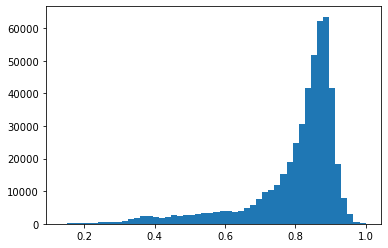

In [13]:
plt.hist(np.amax(probs, axis=1), bins=50);

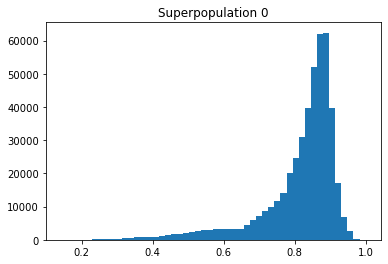

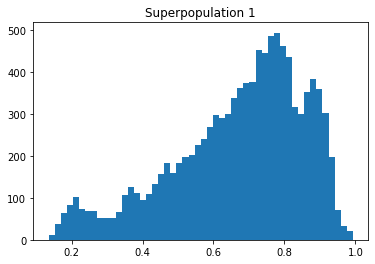

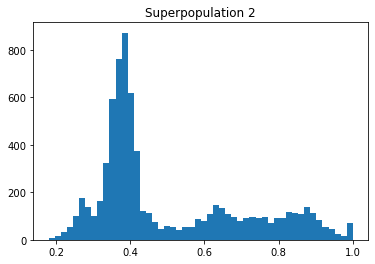

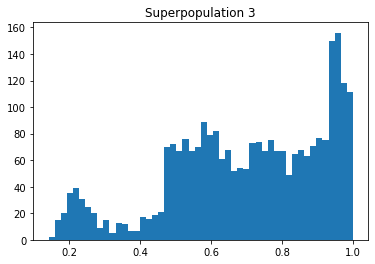

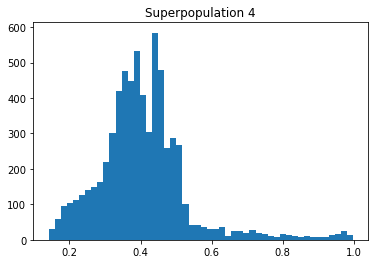

In [17]:
for i in range(5):
    plt.figure()
    plt.title(f"Superpopulation {i}")
    plt.hist(np.amax(probs[ukb_tg_projections.pred_superpopulation==i], axis=1), bins=50);

In [21]:
ancestry_model.classes_

array(['BEB', 'CHB', 'ESN', 'FIN', 'GBR', 'JPT', 'KHV', 'LWK', 'MSL',
       'PEL', 'PJL', 'PUR', 'STU', 'TSI', 'YRI'], dtype=object)

In [31]:
superpop_list = np.vectorize(lambda x: superpopulations_map[x])(ancestry_model.classes_)

In [32]:
superpop_list

array([1, 3, 2, 0, 0, 3, 3, 2, 2, 4, 1, 4, 1, 0, 2])

In [44]:
superpop_probs = np.zeros((ukb_tg_projections.shape[0], 5))
for i in range(5):
    superpop_probs[:, i] = np.sum(probs[:, superpop_list == i], axis=1)

In [48]:
ukb_tg_projections['superpop_prob'] = np.amax(superpop_probs, axis=1)

In [51]:
for i in range(ukb_tg_projections.shape[0]):
    ukb_tg_projections.loc[i, 'superpop_label'] = str(ukb_tg_projections.loc[i, 'pred_superpopulation']) if ukb_tg_projections.loc[i, 'superpop_prob'] > 0.75 else str(ukb_tg_projections.loc[i, 'pred_superpopulation']) + ' (below thresh)'

In [ ]:
px.scatter(ukb_tg_projections, x='SCORE1_AVG', y='SCORE2_AVG', color='pred_superpopulation').write_html('superpopulations_pc1v2.html')

In [28]:
np.sum(probs[:, np.vectorize(lambda x: superpopulations_map[x])(ancestry_model.classes_) == 4][ukb_tg_projections.pred_superpopulation==4], axis=1)

array([0.462, 0.36 , 0.403, ..., 0.411, 0.455, 0.467])

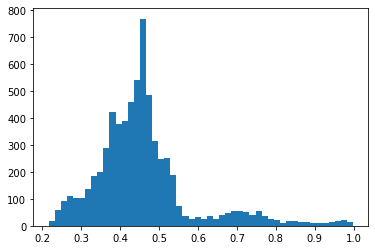

In [29]:
plt.hist(np.sum(probs[:, np.vectorize(lambda x: superpopulations_map[x])(ancestry_model.classes_) == 4][ukb_tg_projections.pred_superpopulation==4], axis=1), bins=50);

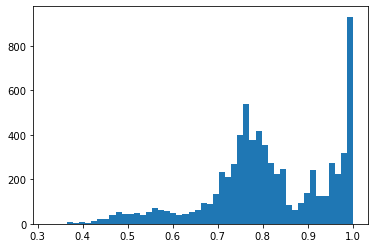

In [30]:
plt.hist(np.sum(probs[:, np.vectorize(lambda x: superpopulations_map[x])(ancestry_model.classes_) == 2][ukb_tg_projections.pred_superpopulation==2], axis=1), bins=50);

In [55]:
ukb_tg_projections.superpop_label.value_counts()

0                   447760
0 (below thresh)     13342
1                     9546
4 (below thresh)      6292
2                     5243
3                     2385
2 (below thresh)      2066
1 (below thresh)      1110
3 (below thresh)       329
4                      304
Name: superpop_label, dtype: int64

In [53]:
px.scatter(ukb_tg_projections, x='SCORE1_AVG', y='SCORE2_AVG', color='superpop_label').write_html('superpopulations_pc1v2_thresh.html')

In [54]:
px.scatter(ukb_tg_projections, x='SCORE3_AVG', y='SCORE4_AVG', color='superpop_label').write_html('superpopulations_pc3v4_thresh.html')